### Import Packages

In [161]:

# stochastic optimization for feature selection
from numpy import mean
from numpy.random import rand
from numpy.random import choice
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import time
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
import matplotlib
%matplotlib inline

### Define Stochastic Gradient Function for determining the optimal number of features

In [2]:
# objective function
def objective(X, y, subset):
    # get the column indexes
    ix = [i for i, x in enumerate(subset) if x]
    # check for the current column (all False)
    if len(ix) == 0:
        return 0.0
    # subset the columns
    X_new = X[:, ix]
    # define the prediction model
    model = RandomForestClassifier()
    # evaluate model
    scores = cross_val_score(model, X_new, y, scoring='accuracy', cv=3, n_jobs=-1)
    # summarize the model performance scores
    result = mean(scores)
    return result, ix
 
# define the mutation operator
def mutate(solution, p_mutate):
    # make a copy of the solution
    child = solution.copy()
    for i in range(len(child)):
        # check for any mutation
        if rand() < p_mutate:
            # flip the inclusion cond
            child[i] = not child[i]
    return child
 
# Define a hill climbing local search algorithm
def hillclimbing(X, y, objective, n_iter, p_mutate, verbose = None):
    # generate the initial point
    solution = choice([True, False], size=X.shape[1])
    # evaluate the score of the initial point
    solution_eval, ix = objective(X, y, solution)
    # iteratively run the hill climb
    for i in range(n_iter):
        # take a step
        candidate = mutate(solution, p_mutate)
        # evaluate candidate point
        candidate_eval, ix = objective(X, y, candidate)
        # check if we should keep the new point
        if candidate_eval >= solution_eval:
            # store the new point
            solution, solution_eval = candidate, candidate_eval
        # report progress
        if verbose == True:
            print('>%d f(%s) = %f' % (i+1, len(ix), solution_eval))
        else:
            pass
    return solution, solution_eval
 

### Brief Data Exploration

In [3]:
#Medium sized data
digits = load_digits()

In [4]:
#Large data
X_df, y_df = fetch_openml('mnist_784', version=1, return_X_y=True)

#Sample
X_df, y_df = X_df[0:10000], y_df[0:10000]

### Display of a sample of the data

#### Large data

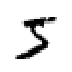

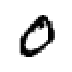

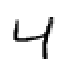

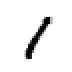

In [5]:
for i in range(4):
    some_digit = X_df.values[i]
    some_digit_image = some_digit.reshape(28, 28)
    plt.subplot(1, 5, i + 1)
    plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis('off')
    plt.show()

#### Medium dataset

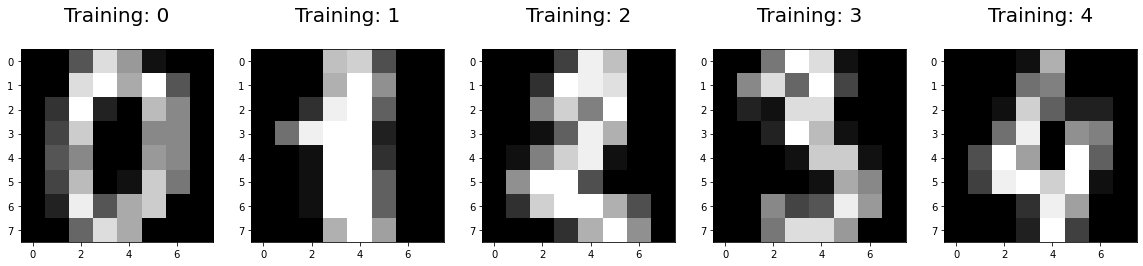

In [6]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], 
                                           digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20);

#### Split data to train and test

In [172]:
# define dataset
X, y = X_df.values, y_df
#digits.data, digits.target
# define the total iterations
n_iter = 10
# probability of including/excluding a column
p_mut = 0.1
# perform the hill climbing search
subset, score = hillclimbing(X, y, objective, n_iter, p_mut, True)
# convert into column indexes
ix = [i for i, x in enumerate(subset) if x]
ix_lar = ix
ix_lar_act = X.shape[1]
print('Done!')
print('Optimal number of features is %d with a score of %f' % (len(ix), score))

>1 f(372) = 0.935900
>2 f(390) = 0.935900
>3 f(371) = 0.935900
>4 f(384) = 0.935900
>5 f(380) = 0.935900
>6 f(372) = 0.935900
>7 f(385) = 0.935900
>8 f(366) = 0.935900
>9 f(352) = 0.935900
>10 f(376) = 0.935900
Done!
Optimal number of features is 372 with a score of 0.935900


In [173]:
#Select the optimal number of features
X_sel = X[:,ix]

In [174]:
print('The original dataset has',X.shape[1], 'columns and',X.shape[0], 'Observations')

The original dataset has 784 columns and 10000 Observations


In [175]:
print('The new dataset has',X_sel.shape[1], 'columns and',X_sel.shape[0], 'Observations')

The new dataset has 372 columns and 10000 Observations


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_df,
                                                   test_size=0.25,
                                                   random_state=0)

X_train = (X_train).astype('float32') # all pixel values
X_test = X_test.astype('float32')

In [177]:

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, 
                                                    y_df,
                                                   test_size=0.25,
                                                   random_state=0)

In [178]:
X_train_sel = (X_train_sel).astype('float32') # all pixel values
X_test_sel = X_test_sel.astype('float32')

#### Performance of classification models using the original and feature selected data

In [179]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds

cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")


y_test_pred_mnist = cross_val_predict(sgd_clf, X_test, y_test, cv =3)
mnist_x_perf = accuracy_score(y_test_pred_mnist, y_test)

lar_time_x= time.process_time() - start

In [180]:
print(classification_report(y_test, y_test_pred_mnist))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       253
           1       0.93      0.94      0.93       269
           2       0.88      0.80      0.84       248
           3       0.84      0.79      0.82       278
           4       0.90      0.84      0.87       238
           5       0.71      0.78      0.74       228
           6       0.90      0.92      0.91       257
           7       0.85      0.87      0.86       249
           8       0.75      0.72      0.73       249
           9       0.72      0.80      0.76       231

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



#### Feature selection performance

In [181]:
start = time.process_time()
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train,y_train)

cross_val_score(sgd_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")


y_test_pred_sel_mnist = cross_val_predict(sgd_clf, X_test_sel, y_test_sel, cv =3)
mnist_x_sel_perf = accuracy_score(y_test_pred_sel_mnist, y_test)
lar_time_sel = time.process_time() - start

In [182]:
print(classification_report(y_test_sel, y_test_pred_sel_mnist))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       253
           1       0.88      0.90      0.89       269
           2       0.80      0.79      0.79       248
           3       0.81      0.76      0.78       278
           4       0.86      0.82      0.84       238
           5       0.78      0.70      0.74       228
           6       0.90      0.88      0.89       257
           7       0.87      0.83      0.85       249
           8       0.64      0.76      0.69       249
           9       0.73      0.78      0.75       231

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



### Naive Bayes

In [183]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds
cross_val_score(nb_clf, X_test, y_test, cv=3, scoring="accuracy")

#make predictions
y_test_pred_mnist_nb = cross_val_predict(nb_clf, X_test, y_test, cv =3)

mnist_nb_x_perf = accuracy_score(y_test_pred_mnist_nb, y_test)


lar_nb_time_x = time.process_time() - start

In [184]:
print(classification_report(y_test, y_test_pred_mnist_nb))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       253
           1       0.67      0.90      0.77       269
           2       0.70      0.42      0.52       248
           3       0.81      0.38      0.52       278
           4       0.78      0.54      0.64       238
           5       0.62      0.24      0.34       228
           6       0.64      0.88      0.74       257
           7       0.87      0.43      0.58       249
           8       0.33      0.45      0.38       249
           9       0.42      0.89      0.57       231

    accuracy                           0.60      2500
   macro avg       0.66      0.60      0.58      2500
weighted avg       0.66      0.60      0.59      2500



In [185]:
start = time.process_time()
nb_clf = GaussianNB()
nb_clf.fit(X_train_sel,y_train)

cross_val_score(nb_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")


y_test_pred_sel_mnist_nb = cross_val_predict(nb_clf, X_test_sel, y_test_sel, cv =3)

mnist_nb_x_perf_sel = accuracy_score(y_test_pred_sel_mnist_nb, y_test)

lar_nb_time_sel = time.process_time() - start

In [186]:
print(classification_report(y_test_sel, y_test_pred_sel_mnist_nb))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       253
           1       0.59      0.92      0.72       269
           2       0.76      0.44      0.55       248
           3       0.75      0.47      0.58       278
           4       0.72      0.51      0.60       238
           5       0.69      0.48      0.56       228
           6       0.69      0.84      0.76       257
           7       0.78      0.41      0.53       249
           8       0.45      0.43      0.44       249
           9       0.39      0.82      0.53       231

    accuracy                           0.62      2500
   macro avg       0.66      0.62      0.61      2500
weighted avg       0.66      0.62      0.61      2500



## Medium sized dataset

In [188]:
# define dataset
X, y = digits.data, digits.target
# define the total iterations
n_iter = 100
# probability of including/excluding a column
p_mut = 0.1
# perform the hill climbing search
subset, score = hillclimbing(X, y, objective, n_iter, p_mut, False)
# convert into column indexes
ix = [i for i, x in enumerate(subset) if x]
ix_med = ix
ix_med_act = X.shape[1]
print('Done!')
print('Optimal number of features is %d with a score of %f' % (len(ix), score))

Done!
Optimal number of features is 38 with a score of 0.939343


In [189]:
#Select the optimal number of features
X_sel = X[:,ix]

In [190]:
print('The original dataset has',X.shape[1], 'columns and',X.shape[0], 'Observations')

The original dataset has 64 columns and 1797 Observations


In [191]:
print('The new dataset has',X_sel.shape[1], 'columns and',X_sel.shape[0], 'Observations')

The new dataset has 38 columns and 1797 Observations


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size=0.25,
                                                   random_state=0)

X_train = (X_train).astype('float32') # all pixel values
X_test = X_test.astype('float32')

In [193]:

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, 
                                                    y,
                                                   test_size=0.25,
                                                   random_state=0)

In [194]:
X_train_sel = (X_train_sel).astype('float32') # all pixel values
X_test_sel = X_test_sel.astype('float32')

#### Performance of classification models using the original and feature selected data

In [195]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds
cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")


y_test_pred_digits = cross_val_predict(sgd_clf, X_test, y_test, cv =3)

digits_x_perf = accuracy_score(y_test_pred_digits, y_test)
med_time_x = time.process_time() - start

In [196]:
print(classification_report(y_test, y_test_pred_digits))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.90      0.84      0.87        43
           2       0.97      0.84      0.90        44
           3       0.87      0.87      0.87        45
           4       0.90      0.92      0.91        38
           5       0.92      0.96      0.94        48
           6       0.98      1.00      0.99        52
           7       0.94      0.92      0.93        48
           8       0.77      0.83      0.80        48
           9       0.82      0.85      0.83        47

    accuracy                           0.90       450
   macro avg       0.91      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



#### Feature selection performance

In [197]:
start = time.process_time()
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train,y_train)

cross_val_score(sgd_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")


y_test_pred_sel_digits = cross_val_predict(sgd_clf, X_test_sel, y_test_sel, cv =3)

digits_x_perf_sel = accuracy_score(y_test_pred_sel_digits, y_test)

med_time_sel = time.process_time() - start

In [198]:
print(classification_report(y_test_sel, y_test_pred_sel_digits))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.84      0.86      0.85        43
           2       0.95      0.89      0.92        44
           3       0.86      0.93      0.89        45
           4       0.94      0.89      0.92        38
           5       0.87      0.98      0.92        48
           6       0.98      0.98      0.98        52
           7       0.93      0.88      0.90        48
           8       0.80      0.92      0.85        48
           9       0.95      0.74      0.83        47

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



### Naive Bayes

In [199]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds
cross_val_score(nb_clf, X_test, y_test, cv=3, scoring="accuracy")

#make predictions
y_test_pred_digits = cross_val_predict(nb_clf, X_test, y_test, cv =3)

digits_x_perf_nb = accuracy_score(y_test_pred_digits, y_test)
med_nb_time_x = time.process_time() - start

In [200]:
print(classification_report(y_test, y_test_pred_digits))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.82      0.77      0.80        43
           2       0.89      0.73      0.80        44
           3       0.90      0.82      0.86        45
           4       0.89      0.82      0.85        38
           5       0.90      0.90      0.90        48
           6       0.91      0.96      0.93        52
           7       0.80      0.92      0.85        48
           8       0.61      0.90      0.72        48
           9       0.88      0.64      0.74        47

    accuracy                           0.84       450
   macro avg       0.86      0.84      0.84       450
weighted avg       0.86      0.84      0.84       450



In [201]:
start = time.process_time()
nb_clf = GaussianNB()
nb_clf.fit(X_train_sel,y_train)

cross_val_score(nb_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")

y_test_pred_sel_digits_nb = cross_val_predict(nb_clf, X_test_sel, y_test_sel, cv =3)

digits_nb_x_perf_sel = accuracy_score(y_test_pred_sel_digits_nb, y_test)

med_nb_time_sel = time.process_time() - start

In [202]:
print(classification_report(y_test_sel, y_test_pred_sel_digits_nb))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.78      0.72      0.75        43
           2       0.76      0.93      0.84        44
           3       0.87      0.76      0.81        45
           4       0.88      0.79      0.83        38
           5       0.91      0.88      0.89        48
           6       0.88      0.96      0.92        52
           7       0.82      0.94      0.87        48
           8       0.84      0.85      0.85        48
           9       0.83      0.72      0.77        47

    accuracy                           0.85       450
   macro avg       0.86      0.85      0.85       450
weighted avg       0.85      0.85      0.85       450



## Small dataset

> Wincosin Breast Cancer Dataset

In [203]:


cancer = load_breast_cancer()

X, y = cancer.data, cancer.target

In [204]:
# define the total iterations
n_iter = 100
# probability of including/excluding a column
p_mut = 0.1
# perform the hill climbing search

# perform the hill climbing search
subset, score = hillclimbing(X, y, objective, n_iter, p_mut, False)
# convert into column indexes
ix = [i for i, x in enumerate(subset) if x]
ix_sma = ix
ix_sma_act = X.shape[1]
print('Done!')
print('Optimal number of features is %d with a score of %f' % (len(ix), score))

Done!
Optimal number of features is 16 with a score of 0.968375


In [205]:
#Select the optimal number of features
X_sel = X[:,ix]

In [206]:
print('The original dataset has',X.shape[1], 'columns and',X.shape[0], 'Observations')

The original dataset has 30 columns and 569 Observations


In [207]:
print('The new dataset has',X_sel.shape[1], 'columns and',X_sel.shape[0], 'Observations')

The new dataset has 16 columns and 569 Observations


In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size=0.25,
                                                   random_state=0)

In [209]:

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, 
                                                    y,
                                                   test_size=0.25,
                                                   random_state=0)

In [210]:
X_train_sel = (X_train_sel).astype('float32') # all pixel values
X_test_sel = X_test_sel.astype('float32')

### Stochastic Gradient Descent

In [211]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds
cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")
y_test_pred_cancer = cross_val_predict(sgd_clf, X_test, y_test, cv =3)
cancer_x_perf = accuracy_score(y_test_pred_cancer, y_test)
sma_time_x = time.process_time() - start

In [212]:
print(classification_report(y_test_sel, y_test_pred_cancer))

              precision    recall  f1-score   support

           0       0.52      0.83      0.64        53
           1       0.85      0.56      0.67        90

    accuracy                           0.66       143
   macro avg       0.69      0.69      0.66       143
weighted avg       0.73      0.66      0.66       143



In [213]:
start = time.process_time()
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train_sel,y_train)

cross_val_score(sgd_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")


y_test_pred_sel_cancer = cross_val_predict(sgd_clf, X_test_sel, y_test_sel, cv =3)

cancer_x_perf_sel = accuracy_score(y_test_pred_sel_cancer, y_test)

sma_time_sel = time.process_time() - start

In [214]:
print(classification_report(y_test_sel, y_test_pred_sel_cancer))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        53
           1       0.75      0.84      0.80        90

    accuracy                           0.73       143
   macro avg       0.71      0.69      0.69       143
weighted avg       0.72      0.73      0.72       143



### Naive Bayes

In [215]:
start = time.process_time()
# Stochastic Gradient Descent (it can handle big datasets every efficiently)
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)

# Performance Measure with k fold cross validation with three folds
cross_val_score(nb_clf, X_test, y_test, cv=3, scoring="accuracy")

#make predictions
y_test_pred_cancer_nb = cross_val_predict(nb_clf, X_test, y_test, cv =3)

cancer_nb_x_perf_nb = accuracy_score(y_test_pred_cancer_nb, y_test)

sma_nb_time_x = time.process_time() - start

In [216]:
print(classification_report(y_test, y_test_pred_cancer_nb))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        53
           1       0.95      0.97      0.96        90

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



In [217]:
start = time.process_time()
nb_clf = GaussianNB()
nb_clf.fit(X_train_sel,y_train)

cross_val_score(nb_clf, X_test_sel, y_test_sel, cv=3, scoring="accuracy")

y_test_pred_sel_cancer_nb = cross_val_predict(nb_clf, X_test_sel, y_test_sel, cv =3)
cancer_nb_x_perf_nb_sel = accuracy_score(y_test_pred_sel_cancer_nb, y_test)

sma_nb_time_sel = time.process_time() - start

In [218]:
print(classification_report(y_test_sel, y_test_pred_sel_cancer_nb))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        53
           1       0.95      0.99      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



##### Mnist Performance

In [219]:
perf_mnist = pd.DataFrame()

perf_mnist['Model'] = ['SGD', 'SGD', 'Naive Bayes', 'Naive Bayes']

perf_mnist['Number of features'] = [ix_lar_act, len(ix_lar), ix_lar_act, len(ix_lar)]


perf_mnist['Classification Accuracy (%)'] = [mnist_x_perf, mnist_x_sel_perf, mnist_nb_x_perf, mnist_nb_x_perf_sel]
perf_mnist['Classification Accuracy (%)'] = perf_mnist['Classification Accuracy (%)']*100

perf_mnist['Time taken'] = [lar_time_x, lar_time_sel, lar_nb_time_x, lar_nb_time_sel]
round(perf_mnist, 4)

,Model,Number of features,Classification Accuracy (%),Time taken
0,SGD,784,84.20,13.1719
1,SGD,372,81.72,11.2812
2,Naive Bayes,784,60.08,1.0625
3,Naive Bayes,372,61.80,0.4688


##### Digits Performance

In [220]:
perf_digits = pd.DataFrame()

perf_digits['Model'] = ['SGD', 'SGD', 'Naive Bayes', 'Naive Bayes']

perf_digits['Number of features'] = [ix_med_act, len(ix_med), ix_med_act, len(ix_med)]

perf_digits['Classification Accuracy (%)'] = [digits_x_perf, digits_x_perf_sel, digits_x_perf_nb, digits_nb_x_perf_sel]

perf_digits['Classification Accuracy (%)'] = perf_digits['Classification Accuracy (%)']*100
perf_digits['Time taken'] = [med_time_x, med_time_sel, med_nb_time_x, med_nb_time_sel]
round(perf_digits, 4)

,Model,Number of features,Classification Accuracy (%),Time taken
0,SGD,64,90.2222,0.2344
1,SGD,38,90.6667,0.3438
2,Naive Bayes,64,84.0000,0.0938
3,Naive Bayes,38,85.1111,0.0625


##### Cancer Performance

In [222]:
perf_cancer = pd.DataFrame()

perf_cancer['Model'] = ['SGD', 'SGD', 'Naive Bayes', 'Naive Bayes']


perf_cancer['Number of features'] = [ix_sma_act, len(ix_sma), ix_sma_act, len(ix_sma)]

perf_cancer['Classification Accuracy (%)'] = [cancer_x_perf, cancer_x_perf_sel,cancer_nb_x_perf_nb, cancer_nb_x_perf_nb_sel ]

perf_cancer['Classification Accuracy (%)'] = perf_cancer['Classification Accuracy (%)']*100

perf_cancer['Time taken'] = sma_time_x, sma_time_sel, sma_nb_time_x, sma_nb_time_sel
round(perf_cancer, 4)

,Model,Number of features,Classification Accuracy (%),Time taken
0,SGD,30,65.7343,0.0156
1,SGD,16,72.7273,0.0156
2,Naive Bayes,30,94.4056,0.0156
3,Naive Bayes,16,95.8042,0.0469
